In [4]:
import os,sys
import argparse
import copy

import numpy as np
from iminuit import Minuit
import pandas as pd
from scipy import interpolate, integrate
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
import healpy as hp
from tqdm import *

from local_dirs import *
from minuit_functions import call_ll

# Additional modules
sys.path.append(nptf_old_dir)
sys.path.append(work_dir + '/AccurateSmoothing')
sys.path.append(work_dir + '/mkDMMaps')
import fermi.fermi_plugin as fp
import mkDMMaps
import king_smooth as ks
import LL_inten_to_xsec as Litx

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask

In [2]:
# Feynman dirs
work_dir = '/group/hepheno/smsharma/Fermi-LSS/'
psf_dir='/mnt/hepheno/CTBCORE/psf_data/'
maps_dir='/mnt/hepheno/CTBCORE/'
fermi_data_dir='/mnt/hepheno/FermiData/'
data_folder='/tigress/Fermi-LSS/AdditionalData/'

In [5]:
class fake_code:
    def __init__(self, n,var_names=['False']):
        self.co_argcount = n
        if var_names[0] != 'False':
            self.co_varnames = tuple(var_names)
        else:
            self.co_varnames = tuple(map(str, range(n)))

class call_ll:
    def __init__(self, n,ll,var_names=['False']):
        self.n = n
        self.func_code = fake_code(n,var_names=var_names)
        self.ll = ll
    def __call__(self, *args):
        return - self.ll([arg for arg in args])

In [8]:
imc = 0
iobj = 0

In [10]:
# Global settings
nside=128
eventclass=5 # 2 (Source) or 5 (UltracleanVeto)
eventtype=0 # 0 (all), 3 (bestpsf) or 5 (top3 quartiles)
diff = 'p7' # 'p6', 'p7', 'p8'
emin = 0
emax = 1

# Load the Fermi plugin
f_global = fp.fermi_plugin(maps_dir,fermi_data_dir=fermi_data_dir,work_dir=work_dir,CTB_en_min=emin,CTB_en_max=emax+1,nside=nside,eventclass=eventclass,eventtype=eventtype,newstyle=1,data_July16=True)

In [12]:
# Load necessary templates
f_global.add_diffuse_newstyle(comp = diff,eventclass = eventclass, eventtype = eventtype) 
f_global.add_iso()  
# f_global.add_ps_model()
ps_temp = np.load('../AdditionalData/ps_map.npy')
f_global.add_template_by_hand(comp='ps_model',template=ps_temp)
f_global.add_bubbles() 

In [14]:
catalog = pd.read_csv("../data/Catalogs//DarkSky_ALL_200,200,200_v3.csv")
l = catalog.l.values[iobj]
b = catalog.b.values[iobj]

mk = mkDMMaps.mkDMMaps(z = catalog.z[iobj], r_s = catalog.rvir_inf.values[iobj]/catalog.cvir_inf.values[iobj]*1e-3, J_0 = 10**catalog.mulog10J_inf.values[iobj],ell = l*np.pi/180,b = b*np.pi/180,nside=128, Burkert=False)
the_map = mk.map
DM_template = the_map/np.max(the_map)

In [15]:
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]

In [59]:
A_ary = 10**np.linspace(-6,6,200)
LL_inten_ary = np.zeros((len(ebins),len(A_ary)))
inten_ary = np.zeros((len(ebins),len(A_ary)))

for iebin, ebin in tqdm(enumerate(np.arange(emin,emax))):
    
    #######################
    # Prepare templates   #
    #######################

    mc_file = np.load(mc_dir + "/MC_allhalos_p7_nodm_v"+str(imc)+".npy")[ebin].astype(np.float64)

    fermi_data = f_global.CTB_count_maps[iebin].astype(np.int32)
    fermi_exposure = f_global.CTB_exposure_maps[iebin]

    dif = f_global.template_dict[diff][iebin]
    iso = f_global.template_dict['iso'][iebin]
    psc = f_global.template_dict['ps_model'][iebin]
    bub = f_global.template_dict['bubs'][iebin]
    
    DM_intensity_base = np.sum(DM_template/fermi_exposure)/(4*np.pi)

    #######################
    # NPTFit fit as usual #
    #######################

    n = nptfit.NPTF(tag='norm_bin_'+str(ebin))
    n.load_data(mc_file, fermi_exposure)

    # Mask used in analysis
    analysis_mask = cm.make_mask_total(mask_ring = True, inner = 0, outer = 10, ring_b = b, ring_l = l)
    n.load_mask(analysis_mask)

    n.add_template(dif, diff)
    n.add_template(iso, 'iso')
    n.add_template(psc, 'psc')
    n.add_template(bub, 'bub')

    n.add_poiss_model(diff, '$A_\mathrm{dif}$', [0,10], False)
    n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
    n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,10], False)
    n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,10], False)

    n.configure_for_scan()
    
    ##########
    # Minuit #
    ##########

    keys = n.poiss_model_keys
    limit_dict = {}
    init_val_dict = {}
    step_size_dict = {}
    for key in keys:
        limit_dict['limit_'+key] = (0,10)
        init_val_dict[key] = 0.1
        step_size_dict['error_'+key] = 0.01
    other_kwargs = {'print_level': 1}
    z = limit_dict.copy()
    z.update(other_kwargs)
    z.update(limit_dict)
    z.update(init_val_dict)
    z.update(step_size_dict)
    f = call_ll(len(keys),n.ll,keys)
    m = Minuit(f,errordef=1,**z)
    m.migrad()
    
    #######################
    # Make background sum #
    #######################

    bkg_sum = np.zeros(len(mc_file))
    for key in keys:
        bkg_sum += n.templates_dict[key]*m.values[key]
        
    n2 = nptfit.NPTF(tag='dm_bin_'+str(ebin))
    n2.load_data(mc_file, fermi_exposure)
    n2.load_mask(analysis_mask)
    n2.add_template(bkg_sum, 'bkg_sum')
    n2.add_poiss_model('bkg_sum', '$A_\mathrm{bkg}$', fixed=True, fixed_norm=1.0)
    
    #######################
    # Get intensity LLs   #
    #######################
                       
    for iA, A in enumerate(A_ary):
        new_n2 = copy.deepcopy(n2)
        new_n2.add_template(A*DM_template,'DM')
        new_n2.add_poiss_model('DM','DM',False,fixed=True,fixed_norm=1.0)
        new_n2.configure_for_scan()
        max_LL = new_n2.ll([])
        
        LL_inten_ary[iebin, iA] = max_LL
        inten_ary[iebin, iA] = DM_intensity_base*A

0it [00:00, ?it/s]

FCN = 5459.45163669 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 2.33869026787e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,p7,1.18801,0.00968154,0,0,0.0,10.0,
2,iso,8.83146,0.464879,0,0,0.0,10.0,
3,psc,1.00968,0.0279165,0,0,0.0,10.0,
4,bub,0.1,6.57653,0,0,0.0,10.0,


1it [00:04,  4.15s/it]


In [62]:
np.sum(mc_file*np.logical_not(analysis_mask)) != 0

True

In [66]:
1 and 5.

5.0

In [53]:
dNdLogx_df = pd.read_csv('../AdditionalData/AtProduction_gammas.dat', delim_whitespace=True)

marr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])

channel = 'b'

PPnoxsec_arr = np.zeros(shape=(len(marr),len(ebins)))
for mi in range(len(marr)):
    dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(marr[mi])))))[['Log[10,x]',channel]]
    Egamma = np.array(marr[mi]*(10**dNdLogx_ann_df['Log[10,x]']))
    dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
    dNdE_interp = interp1d(Egamma, dNdEgamma)
    for ei in range(len(ebins)-1): # -1 because ebins-1 bins, ebins edges
        # Only have flux if m > Ebin
        if ebins[ei] < marr[mi]:
            if ebins[ei+1] < marr[mi]:
                # Whole bin is inside
                PPnoxsec_arr[mi,ei] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[ei], ebins[ei+1])[0]
            else:
                # Bin only partially contained
                PPnoxsec_arr[mi,ei] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[ei], marr[mi])[0]
PPnoxsec_arr = PPnoxsec_arr

In [21]:
xsecs = np.logspace(-33,-18,301)
LL_ary_xsec = np.zeros((len(marr),len(xsecs)))

for im in tqdm(range(len(marr))):
    for ixsec, xsec in enumerate(xsecs):
        for iebin in range(len(ebins)):
            intval = PPnoxsec_arr[im][iebin]*10**catalog.mulog10J_inf.values[iobj]*xsec
            LL_ary_xsec[im,ixsec] += 2*np.interp(intval,inten_ary[iebin], LL_inten_ary[iebin])

100%|██████████| 53/53 [00:07<00:00,  7.48it/s]


(-2.71, 2)

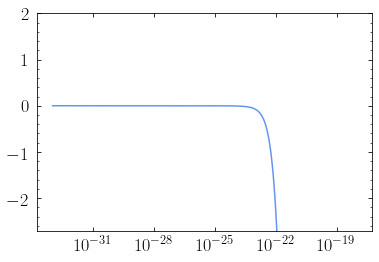

In [22]:
plt.plot(xsecs,LL_ary_xsec[52]-LL_ary_xsec[52][0])
plt.xscale("log")
plt.ylim(-2.71,2)